<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the data</a></span></li><li><span><a href="#Add-new-data" data-toc-modified-id="Add-new-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Add new data</a></span></li><li><span><a href="#From-JSON-to-pands" data-toc-modified-id="From-JSON-to-pands-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>From JSON to pands</a></span></li><li><span><a href="#Check-with-unseen-data" data-toc-modified-id="Check-with-unseen-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check with unseen data</a></span></li></ul></div>

In [2]:
#LIBRARIES
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.cluster import DBSCAN

from collections import defaultdict
from sklearn.metrics import (auc, average_precision_score, 
                              roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, cohen_kappa_score)
from sklearn.metrics import confusion_matrix

import pickle
import joblib

In [2]:
# Load models (deserialize)
with open('models_provinces_copy4.pickle', 'rb') as handle:
    models_dictionary = pickle.load(handle)

In [3]:
#Loading the scaler
# Load models (deserialize)
with open('minmax_provinces.pickle', 'rb') as handle:
    scaler_provinces = pickle.load(handle)

In [42]:
def dbscan_newobservation(original,new_observation):
    
    #Preprocessing of the original dataframe
    original.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']
    new_observation.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']
    
    df1=original[original['temperature'].notna()]
    df1=df1[df1['humidity'].notna()]
    df1=df1[df1['pressure'].notna()]
    
    df1['precipitation'].fillna(0, inplace=True)
    df1['wind_speed'].fillna(0, inplace=True)
    df1["wind_direction"].fillna("Calma", inplace = True) 
    df1=df1.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])
    
    #New data
    if (new_observation['temperature'].isnull().values | new_observation['humidity'].isnull().values | new_observation['pressure'].isnull().values):
        return print('Too many missing values')
    else:
        #Preprocessing
        new_observation['precipitation'].fillna(0, inplace=True)
        new_observation['wind_speed'].fillna(0, inplace=True)
        new_observation["wind_direction"].fillna("Calma", inplace = True)
        new_observation_cleaned=new_observation.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])
        #Take the province for the model (it needs to be an array to compare later)
        target_province=new_observation_cleaned['province'].values
        #Drop the province
        new_final=new_observation_cleaned.drop(columns=['province'])
        #Take the province observations from the original dataframe
        df=df1.loc[df1['province'] == target_province[0]]
        #Drop the province from the original
        df=df.drop(columns=['province'])
        #Append two dataframes and reset index
        df_final=df.append(new_final)
        df_final=df_final.reset_index(drop=True) #The new observation is the last one
        #Scaling the data
        X_scaled= scaler_provinces[target_province[0]].transform(df_final)
        X_scaled = pd.DataFrame(X_scaled, columns = df_final.columns)
        results_final=models_dictionary[target_province[0]].fit_predict(X_scaled)
        
        return results_final
       

In [43]:
def check_anomaly(results_final):
    if (results_final[-1]== -1):
        return print("This observation is an anomaly")
    else:
        return print('This is a normal observation')

In [64]:
def dbscan_plot(original,new_observation):
       #Preprocessing of the original dataframe
    original.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']
    new_observation.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']
    
    df1=original[original['temperature'].notna()]
    df1=df1[df1['humidity'].notna()]
    df1=df1[df1['pressure'].notna()]
    
    df1['precipitation'].fillna(0, inplace=True)
    df1['wind_speed'].fillna(0, inplace=True)
    df1["wind_direction"].fillna("Calma", inplace = True) 
    df1=df1.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])
    
    #New data
    if (new_observation['temperature'].isnull().values | new_observation['humidity'].isnull().values | new_observation['pressure'].isnull().values):
        return print('Too many missing values')
    else:
        #Preprocessing
        new_observation['precipitation'].fillna(0, inplace=True)
        new_observation['wind_speed'].fillna(0, inplace=True)
        new_observation["wind_direction"].fillna("Calma", inplace = True)
        new_observation_cleaned=new_observation.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])
        #Take the province for the model (it needs to be an array to compare later)
        target_province=new_observation_cleaned['province'].values
        #Drop the province
        new_final=new_observation_cleaned.drop(columns=['province'])
        #Take the province observations from the original dataframe
        df=df1.loc[df1['province'] == target_province[0]]
        #Drop the province from the original
        df=df.drop(columns=['province'])
        #Append two dataframes and reset index
        df_final=df.append(new_final)
        df_final=df_final.reset_index(drop=True) #The new observation is the last one
        #Scaling the data
        X_scaled= scaler_provinces[target_province[0]].transform(df_final)
        X_scaled = pd.DataFrame(X_scaled, columns = df_final.columns)
        results_final=models_dictionary[target_province[0]].fit_predict(X_scaled)
        
        from matplotlib import cm
        cmap = cm.get_cmap('Set1')
        df_final.plot.scatter(x='wind_speed',y='temperature', c=results_final, cmap=cmap, colorbar = False)
        plt.show()

In [7]:
#LOADING DATA
df=pd.read_csv('data_20190311.csv')

In [3]:
new_df=pd.read_csv('data_20200316.csv')

In [5]:
new_df2=new_df.loc[new_df['MONTH'] == 3]

In [6]:
new_df3=new_df2.loc[new_df2['DAY'] > 11]

In [8]:
new_observation=pd.DataFrame(df.iloc[[5466],:])

In [55]:
test=dbscan_newobservation(df,new_observation)

In [56]:
check_anomaly(test)

This observation is an anomaly


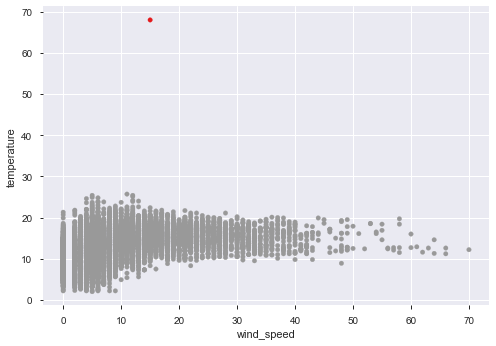

In [65]:
dbscan_plot(df,new_observation)

# Loading the data

In [3]:
#LIBRARIES
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.cluster import DBSCAN

from collections import defaultdict
from sklearn.metrics import (auc, average_precision_score, 
                              roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, cohen_kappa_score)
from sklearn.metrics import confusion_matrix

import pickle
import joblib

In [4]:
#LOADING DATA
df=pd.read_csv('data_20200316.csv')
df.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']

In [4]:
# Remove Temperature  NAs
df1=df[df['temperature'].notna()]

In [5]:
#Precipitation and wind speed NAs will be substituted with 0 values
#Wind direction will be replaced with wind calma
df1['precipitation'].fillna(0, inplace=True)
df1['wind_speed'].fillna(0, inplace=True)
df1["wind_direction"].fillna("Calma", inplace = True) 

C:\Users\Ariadna\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
#Humidity NAs observation are removed
#dir_wind_streak, tendency, wind_streak, id, month, hour, year, station and day are removed 
#wind_direction is removed just for the moment)
df2=df1[df1['humidity'].notna()]
df3=df2.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])

In [117]:
#Correlation matrix showed that the pressure was highly correlated with the temperature 
#I want to keep it for the model, so we remove the NAs
df4=df3[df3['pressure'].notna()]

# Add new data

In [5]:
#Create empty dataframe with the outliers
new_observation=pd.DataFrame(columns=df.columns)

In [18]:
new_observation=pd.DataFrame(df.iloc[[5466],:])

In [46]:
new_observation['temperature']=87
new_observation['wind_speed']=5863

In [233]:
check_anomaly(test)

This observation is an anomaly


In [228]:
new_observation['temperature'].isnull().values
new_observation['temperature']=50
new_observation['humidity']=95
new_observation['pressure']=950

In [209]:
df_final=df_province.append(new_final)

In [210]:
df_final=df_final.reset_index(drop=True)

In [211]:
df_final

,humidity,pressure,precipitation,temperature,wind_speed
0,57.0,1027.2,0.0,18.8,10.0
1,64.0,993.8,0.0,13.7,6.0
2,66.0,959.7,0.0,12.3,6.0
3,65.0,957.1,0.0,12.8,5.0
4,92.0,1026.9,0.0,12.6,21.0
...,...,...,...,...,...
3605,75.0,1019.0,0.0,9.9,15.0
3606,90.0,985.5,0.0,2.8,4.0
3607,92.0,951.2,0.0,4.1,7.0
3608,91.0,948.7,0.0,4.7,0.0


In [214]:
#Scaling the data
X_scaled= scaler_provinces[city[0]].transform(df_final)
X_scaled = pd.DataFrame(X_scaled, columns = df_final.columns)

In [215]:
results_final=models_dictionary[city[0]].fit_predict(X_scaled)

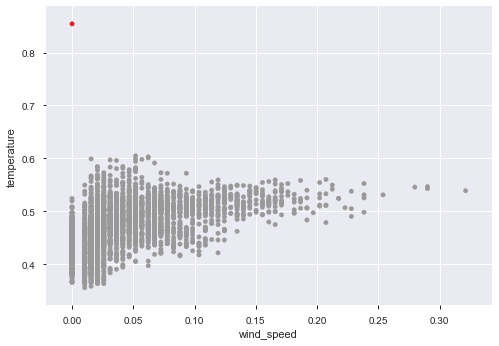

In [216]:
from matplotlib import cm
cmap = cm.get_cmap('Set1')
X_scaled.plot.scatter(x='wind_speed',y='temperature', c=results_final, cmap=cmap, colorbar = False)
plt.show()

# Check with unseen data

In [7]:
model_madrid = joblib.load('model_madrid_copy4.pkl')

In [8]:
scaler_madrid = joblib.load('minmax_madrid.pkl')

In [10]:
new_df3.columns=['id','province', 'dir_wind_streak','humidity','month','pressure','hour','tendency','year','wind_direction',
            'wind_streak','station','day','precipitation','temperature','wind_speed']
    
new_df3=new_df3[new_df3['temperature'].notna()]
new_df3=new_df3[new_df3['humidity'].notna()]
new_df3=new_df3[new_df3['pressure'].notna()]
    
new_df3['precipitation'].fillna(0, inplace=True)
new_df3['wind_speed'].fillna(0, inplace=True)
new_df3["wind_direction"].fillna("Calma", inplace = True) 
new_df3=new_df3.drop(columns=['id', 'dir_wind_streak', 'month','hour', 'tendency', 'year', 'wind_direction', 'wind_streak', 'station',
       'day'])
    

In [12]:
df_madrid=new_df3.loc[new_df3['province'] == 'Madrid']
df_madrid=new_df3.drop(columns=['province'])

In [21]:
df_madrid.to_csv('Unseen_madrid.csv', index=False)